In [1]:
# parameters like vehicle speed, capacity, demands, etc. are not well-defined, 
# so that's probably why the model does not yield results

# the results should be good as it is vaild in theory

In [1]:
import numpy as np
import pandas as pd
import math
import random

import matplotlib.pyplot as plt
% matplotlib inline

from __future__ import print_function
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [2]:
# Locations & Coordinates in North ZhaoXian

global coordinate_array

coordinate_list = [
 'depot', 114.748125, 37.750201,
 'duplicate_depot', 114.748125, 37.750201,
 '宋城', 114.903234,37.85197,
 '赵刀寺', 114.72869,37.781231,
 '东阳台', 114.740252,37.823862,
 '常洋', 114.803039,37.776488,
 '小马圈', 114.804022,37.851744,
 '豆腐庄', 114.851979,37.843736,
 '前大章', 114.865526,37.865367,
 '梅花', 114.8317,37.891582, # 梅花
 '永安', 114.77435,37.83808,
 '乡官', 114.797613,37.867981,
 '曹古疃', 114.779879,37.808557,
 '鲁家庄', 114.767719,37.845097, # 栾城区 
 '安王村', 114.71166,37.798524,
 '北何庄', 114.8197,37.804607,
 '大马', 114.887135,37.868492,
 '投头庄', 114.840102,37.855959,
 '贾店村', 114.726521,37.801013,
 '石家庄', 114.890489,37.824124,
 '范村', 114.698397,37.79639,
 '北解疃', 114.795109,37.7917,
 '西罗村', 114.871172,37.853288,
 '仪停', 114.782591,37.832019,
 '后大章', 114.865834,37.867755,
 '彭家庄', 114.792664,37.804643,
 '林子', 114.910071,37.805321,
 '四德', 114.851108,37.87908,
 '东罗村', 114.882305,37.853451,
 '北轮城', 114.70097,37.788896,
 '肖庄', 114.770207,37.791428,
 '高庄', 114.902043,37.730501,
 '各南', 114.910162,37.817456,
 '泥沟', 114.833553,37.800309,
 '台兴庄', 114.751193,37.812218,
 '马谷庄', 114.762469,37.810494,
 '双庙', 114.78777,37.843918,
 '各子', 114.8928,37.837465, # 一村 二村 三村？
 '大吕村', 114.831951,37.823025,
 '齐家庄', 114.817472,37.846462,
 '北辛庄', 114.866827,37.81841,
 '王家庄', 114.806625,37.835115,
 '尚庄', 114.875416,37.889713, #藁城区
 '固德', 114.772933,37.858432,
 '徐家庄', 114.871728,37.836585,
 '新宅店', 114.726219,37.820187, #村居委会
 '黎村', 114.821105,37.790131,
 '史家庄', 114.798944,37.81971,
 '小吕村', 114.840012,37.816629
]

coordinate_array = np.array(coordinate_list).reshape(49,3)

In [3]:
# Randomly generate 8 locations + warehouse (0) + duplicate warehouse (1) for showcase

rand_loc_list = [0,1]

def rand_loc(rand_loc_list):

    ll = len(rand_loc_list)

    while ll < 10:
        rand_loc_list.append(random.randint(2,48))
        rand_loc_list = list(set(rand_loc_list))
        ll = len(rand_loc_list)

    return rand_loc_list

rand_loc_list = rand_loc(rand_loc_list)
rand_loc_list

# extreme cases: rand_loc_list = [0,1,2,4,14,18,26,31,32,45]

[0, 1, 32, 37, 10, 43, 11, 14, 46, 29]

In [4]:
def time_window():    
    time_windows = [(0,0), (180,300), # depot & duplicate depot, shifts should be even (3-5 hours)
                    (0,540), (0,540), # other visiting locations are not limited
                    (0,540), (0,540),
                    (0,540), (0,540), 
                    (0,540), (0,540)
                   ]
    
    return time_windows

time_windows = time_window()

def rand_demand():
    demands = [0,0,
               random.randint(1,10), random.randint(1,10),
               random.randint(1,10), random.randint(1,10),
               random.randint(1,10), random.randint(1,10),
               random.randint(1,10), random.randint(1,10)
              ]
    
    return demands

demands = rand_demand()

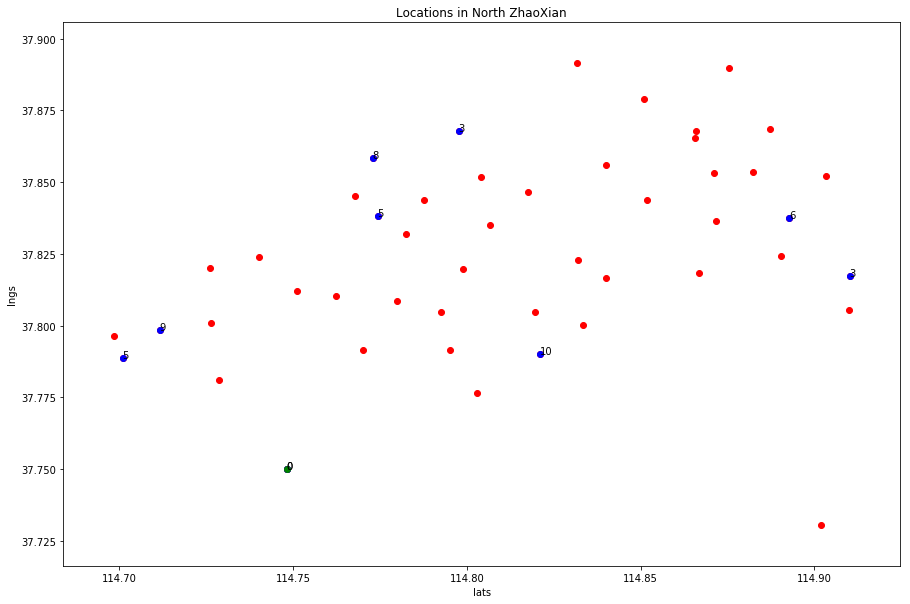

In [5]:
def exp_data_plot(rand_loc_list):
    
    base = [114.748125, 37.750201]
    fig = plt.figure(figsize = (15,10))  
    ax1 = fig.add_subplot(111) 
    
    lats = np.asarray(coordinate_array[:,1], dtype=float)
    lngs = np.asarray(coordinate_array[:,2], dtype=float)
    
    vis_lats = np.asarray(list(coordinate_array[lat,1] for lat in rand_loc_list[:]), dtype=float)
    vis_lngs = np.asarray(list(coordinate_array[lng,2] for lng in rand_loc_list[:]), dtype=float)

    ax1.set_title('Locations in North ZhaoXian')  
    plt.xlabel('lats')  
    plt.ylabel('lngs')  

    ax1.scatter(lats, lngs, c = 'r',marker = 'o') 
    ax1.scatter(vis_lats, vis_lngs, c = 'b',marker = 'o') 
    ax1.scatter(base[0], base[1], c = 'g',marker = 'o')
    
    for i, d in enumerate(demands):
        ax1.annotate(d, (vis_lats[i], vis_lngs[i]))
    
    plt.show() 

exp_data_plot(rand_loc_list)

In [6]:
# Formulate the data

def data_example():
    
    test_data = {}
    test_data['name_locations'] = [str(coordinate_array[nl][0]) for nl in rand_loc_list]
    test_data['coordinates'] = [(float(coordinate_array[coor][1]), 
                                 float(coordinate_array[coor][2])) for coor in rand_loc_list]
    test_data['num_locations'] = len(test_data['coordinates'])
    test_data["num_vehicles"] = 1
    test_data["depot"] = 0
    test_data["time_windows"] = time_windows
    test_data["vehicle_speed"] = 60
    test_data["demands"] = demands
    test_data["vehicle_capacities"] = [100]
    test_data["time_per_demand_unit"] = 5

    return test_data


In [7]:
def manhattan_distance(position_1, position_2):
    # Computes the Manhattan distance between two points in km 
    
    return (abs(position_1[0] - position_2[0]) * 111 + abs(position_1[1] - position_2[1]) * 85)

In [8]:
def create_distance_callback(test_data):
    # Creates callback to return distance between points
    
    _distances = {}

    for from_node in range(test_data["num_locations"]):
        _distances[from_node] = {}
        for to_node in range(test_data["num_locations"]):
            if from_node == to_node:
                _distances[from_node][to_node] = 0
            else:
                _distances[from_node][to_node] = (manhattan_distance(
                    test_data["coordinates"][from_node],
                    test_data["coordinates"][to_node]))

    def distance_callback(from_node, to_node):
        return _distances[from_node][to_node]

    return distance_callback

In [9]:
def create_demand_callback(test_data):
    """Creates callback to get demands at each location."""
    
    def demand_callback(from_node, to_node):
        
        return test_data["demands"][from_node]
    
    return demand_callback


def add_capacity_constraints(routing, test_data, demand_evaluator):
    """Adds capacity constraint"""
    capacity = "Capacity"
    routing.AddDimensionWithVehicleCapacity(
        demand_evaluator,
        0, # null capacity slack
        test_data["vehicle_capacities"], # vehicle maximum capacities
        True, # start cumul to zero
        capacity)

In [10]:
def create_time_callback(test_data):
    """Creates callback to get total times between locations."""
    
    def service_time(node):
        """Gets the service time for the specified location."""
        
        return test_data["demands"][node] * test_data["time_per_demand_unit"]

    def travel_time(from_node, to_node):
        """Gets the travel times between two locations."""
        if from_node == to_node:
            travel_time = 0
        else:
            travel_time = manhattan_distance(
                test_data["locations"][from_node],
                test_data["locations"][to_node]) / test_data["vehicle_speed"]
            
        return travel_time

    def time_callback(from_node, to_node):
        """Returns the total time between the two nodes"""
        serv_time = service_time(from_node)
        trav_time = travel_time(from_node, to_node)
        
        return serv_time + trav_time

    return time_callback

def add_time_window_constraints(routing, test_data, time_callback):
    """Add Global Span constraint"""
    time = "Time"
    horizon = 120
    routing.AddDimension(
        time_callback,
        horizon, # allow waiting time
        horizon, # maximum time per vehicle
        False, 
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    
    for location_node, location_time_window in enumerate(test_data["time_windows"]):
        index = routing.NodeToIndex(location_node)
        time_dimension.CumulVar(index).SetRange(location_time_window[0], location_time_window[1])


In [11]:
def print_solution(test_data, routing, assignment):
    """Prints assignment on console"""
    # Inspect solution.
    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    time_dimension = routing.GetDimensionOrDie('Time')
    total_dist = 0
    time_matrix = 0

    for vehicle_id in range(test_data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {0}:\n'.format(vehicle_id)
        route_dist = 0
        while not routing.IsEnd(index):
            node_index = routing.IndexToNode(index)
            next_node_index = routing.IndexToNode(assignment.Value(routing.NextVar(index)))
            route_dist += manhattan_distance(test_data["locations"][node_index],
                                             test_data["locations"][next_node_index])
            load_var = capacity_dimension.CumulVar(index)
            route_load = assignment.Value(load_var)
            time_var = time_dimension.CumulVar(index)
            time_min = assignment.Min(time_var)
            time_max = assignment.Max(time_var)
            plan_output += ' {0} Load({1}) Time({2},{3}) ->'.format(
                node_index,
                route_load,
                time_min, 
                time_max)
            index = assignment.Value(routing.NextVar(index))

        node_index = routing.IndexToNode(index)
        load_var = capacity_dimension.CumulVar(index)
        route_load = assignment.Value(load_var)
        time_var = time_dimension.CumulVar(index)
        route_time = assignment.Value(time_var)
        time_min = assignment.Min(time_var)
        time_max = assignment.Max(time_var)
        total_dist += route_dist
        time_matrix += route_time
        plan_output += ' {0} Load({1}) Time({2},{3})\n'.format(node_index, route_load,
                                                               time_min, time_max)
        plan_output += 'Distance of the route: {0} m\n'.format(route_dist)
        plan_output += 'Load of the route: {0}\n'.format(route_load)
        plan_output += 'Time of the route: {0} min\n'.format(route_time)
        print(plan_output)
    print('Total Distance of all routes: {0} m'.format(total_dist))
    print('Total Time of all routes: {0} min'.format(time_matrix))


In [12]:
def main():

    # Instantiate the data problem.
    test_data = data_example()

    # Create Routing Model
    routing = pywrapcp.RoutingModel(test_data["num_locations"], 
                                    test_data["num_vehicles"], 
                                    test_data["depot"])
    
    # Define weight of each edge
    distance_callback = create_distance_callback(test_data)
    routing.SetArcCostEvaluatorOfAllVehicles(distance_callback)
    
    # Add Capacity constraint
    demand_callback = create_demand_callback(test_data)
    add_capacity_constraints(routing, test_data, demand_callback)
    
    # Add Time Window constraint
    time_callback = create_time_callback(test_data)
    add_time_window_constraints(routing, test_data, time_callback)

    # Setting first solution heuristic (cheapest addition).
    search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)
    if assignment:
        printer = print_solution(test_data, routing, assignment)


In [22]:
main()

Exception: CP Solver fail